# Sorted spike shapes

author: steeve.laquitaine@epfl.ch  
date: 06.02.2024  
purpose: Explore sorted spike shapes

### Steps

1. Spike sorting (21 min): `notebooks/0_method/4_sorting/silico/0_marques/sorting.ipynb`

2. Waveform extraction (23 min): `notebooks/0_method/5_postpro/silico/0_marques/waveform.ipynb`

In [2]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.extractors as se
from scipy.optimize import minimize
import spikeinterface.full as si_full
import seaborn as sns
import spikeinterface.postprocessing as spost
from concurrent.futures import ProcessPoolExecutor
from ipywidgets import interactive, widgets

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.postpro import waveform

# SETUP PARAMETERS
MS_BEFORE = 3           # ms
MS_AFTER = 3            # ms

# silico
data_conf_sili, param_conf_sili = get_config("vivo_marques", "c26").values()
RAW_PATH_sili = data_conf_sili["recording"]["input"]
PREP_PATH_sili = data_conf_sili["preprocessing"]["output"]["trace_file_path"]
STUDY_FOLDER_sili = data_conf_sili["postprocessing"]["waveform"]["sorted"]["study"]
SORTED_sili = data_conf_sili["sorting"]["sorters"]["kilosort3"]["output"]

# set parameters
PAULK_PERIOD = 0.55
SUN_PERIOD = 4
OUR_PERIOD = 6

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
FIG_SIZE = (4,4)
N_MAJOR_TICKS = 6
N_MINOR_TICKS = 12
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 24
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 1
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
# print(plt.rcParams.keys())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-02-12 11:34:17,643 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-12 11:34:17,658 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Load waveforms

In [3]:
# takes 1 sec
# load stuffs
Recording = si.load_extractor(PREP_PATH_sili)

# curate single units (postprocessing)
Sorting = si.load_extractor(SORTED_sili)

WaveformExtractor = waveform.load(
    Recording,
    study_folder=STUDY_FOLDER_sili,
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER,
)

# list sorted single units
single_units = Sorting.get_property("KSLabel") == "good"
single_units = WaveformExtractor.unit_ids[single_units]
single_units

array([  0,   1,   2,   4,   5,   7,   8,   9,  13,  14,  15,  20,  23,
        24,  30,  37,  39,  41,  43,  44,  47,  48,  52,  53,  56,  57,
        58,  66,  70,  75,  77,  82,  87,  89,  98, 103, 110, 112, 115,
       118, 119, 121, 124, 130, 131, 132, 134, 143, 148, 150, 151, 167,
       168, 169, 170, 184, 187, 189, 190, 191, 192, 199, 200, 201, 203,
       209, 210, 211, 212, 214, 215, 228, 229, 230, 231, 236, 237, 240,
       242, 245, 247, 248, 250, 251, 252, 259, 268, 270, 271, 272, 273,
       276, 281, 282, 284, 285, 287, 288, 289, 291, 294, 295, 298, 299,
       300, 302, 306, 308, 309, 310, 323, 326, 329, 334, 349, 350, 351,
       352, 353, 354, 355, 363, 365, 366, 367, 368, 369, 373, 374, 375,
       378, 379, 381, 391, 393, 397, 398, 400, 401, 403, 404, 405, 409,
       412, 413, 418, 419, 420, 421, 425, 426, 428, 430, 432, 433, 434,
       435, 436, 437, 440, 443, 444, 445, 448, 449, 452, 468, 470, 471,
       472, 477, 479, 483, 486, 488, 489, 490, 492, 493, 498, 49

### Explore spike templates

Observations:

* Pauk et al., plotted spike periods of 0.55 ms (Human data, 0.667 ms for 146.75 points width -> 110 points for 0.5 ms)
* Sun et al., plotted spike periods of 2.6 ms (Cat data)
* Our spikes durations are longer (6 ms, 106.5 points width for 6 ms duration -> 0.5 ms legend bar = 8.875 points width)

* positive spiking
    * 15
    * (39): 16
    * 17
    * 19
    * 20
* regular spiking
    * 0
    * 1
    * 3
    * 5
    * 6
    * 7
    * 11
* fast spiking
    * 13 (8)
    * 14 (9)
    * 10
    * 12
    * 23 (12)
* triphasic
    * 2
    * 4
    * 24 (13)
    * 14
    * 18
    * 21
    * 33

* compound .?

In [29]:
def get_unit_largest_templates_parallelized(array, cell_id):
    # set number of sites
    N_SITES = 1

    # get waveforms
    wfs = WaveformExtractor.get_waveforms(cell_id)

    # get this unit's templates per site
    site_templates = []
    peak_to_peak_amps = []
    for site in range(384):
        template = np.mean(wfs[:, :, site].T, axis=1)
        peak_to_peak_amps.append(max(template) - min(template))
        site_templates.append(template)
    site_templates = np.array(site_templates).T

    # get six largest median spikes (templates) and concatenate as a single row instance for UMAP
    descend_sort_ix = np.argsort(peak_to_peak_amps)[::-1]

    # print site with largest spike
    print("max site: ", descend_sort_ix[0])

    # return waveform
    unit_i_spike = site_templates[:, descend_sort_ix[:N_SITES]].T.flatten()
    return unit_i_spike


def update_plot(unit):
    """plot unit spike template

    Args:
        unit (_type_): _description_
    """
    # select unit to display
    unit_ids = single_units[unit]
    print("unit id:", unit_ids)

    # compute unit's max template
    with ProcessPoolExecutor() as executor:
        site_templates = executor.map(
            get_unit_largest_templates_parallelized,
            np.arange(0, 1, 1),  # dummy not used
            [unit_ids],
        )
    site_templates = list(site_templates)

    # format for wavemap
    templates_for_wavemap = np.array(site_templates[0].tolist())

    # plot
    f, axis = plt.subplots(nrows=1, figsize=(4, 4))
    axis.plot(templates_for_wavemap)
    plt.show()


def plot_spike_profile_example(
    cell_id: int,
    ms_before: float,
    ms_after: float,
    nspike: int,
    color_mean: tuple,
    color: tuple,
):

    # get channels where spike amplitude is maximal
    max_chids = spost.get_template_extremum_channel(
        WaveformExtractor, peak_sign="both", mode="extremum"
    )

    # get cell waveforms
    waveform = WaveformExtractor.get_waveforms(cell_id)

    # get time period
    timestamp = int(WaveformExtractor.nsamples / 2)
    timestep_ms = 1 / WaveformExtractor.sampling_frequency * 1000
    tp_before = int(ms_before / timestep_ms)
    tp_after = int(ms_after / timestep_ms)

    # plot waveform instances in sepecified period
    waveform_instances = waveform[
        :nspike, timestamp - tp_before : timestamp + tp_after, max_chids[cell_id]
    ].T

    # setup plot
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(1, 1, 1)

    # plot
    ax.plot(waveform_instances, color=color)
    ax.plot(np.mean(waveform_instances, axis=1), color=color_mean)
    return fig, ax

In [6]:
# get slider's value interactively
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(single_units) - 1,
    step=1,
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
)

# plot interactively
interactive(update_plot, unit=slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='unit', max=226), Output()), _do…

In [4]:
# check firing rate
UNIT_ID_FOR_FR = 834

unit_pos = np.where(Sorting.unit_ids == UNIT_ID_FOR_FR)[0]
firing_rate = Sorting.get_property("firing_rates")[unit_pos]
firing_rate[0]

4.471090716542883

### Positive spiking

Text(0.5, 0, 'Time to timestamp (ms)')

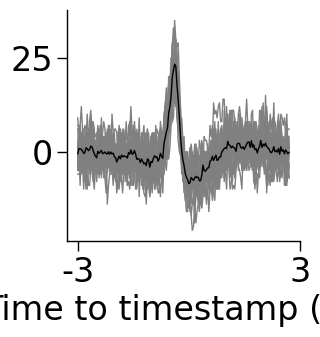

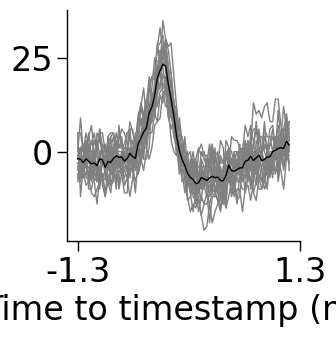

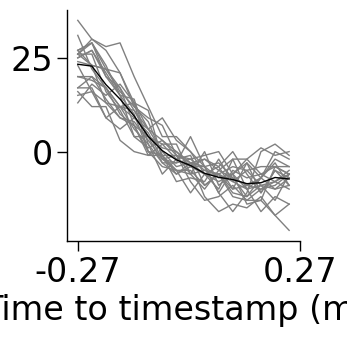

In [33]:
# takes 1 min (6 ms period, same as our simulated spikes)
fig, ax = plot_spike_profile_example(
    cell_id=39,
    ms_before=3,
    ms_after=3,
    nspike=20,
    color_mean=(0, 0, 0),
    color=(0.5, 0.5, 0.5),
)
ax.set_xticks([0, ax.get_xlim()[1]])
ax.set_xticklabels([-3, 3])
ax.set_xlabel("Time to timestamp (ms)")

# takes 1 min (period of 2.6 ms, same as Sun's cats)
fig, ax = plot_spike_profile_example(
    cell_id=39,
    ms_before=1.3,
    ms_after=1.3,
    nspike=20,
    color_mean=(0, 0, 0),
    color=(0.5, 0.5, 0.5),
)
ax.set_xticks([0, ax.get_xlim()[1]])
ax.set_xticklabels([-1.3, 1.3])
ax.set_xlabel("Time to timestamp (ms)")

# takes 1 min (period of 0.55 ms, same as Paulk's humans)
fig, ax = plot_spike_profile_example(
    cell_id=39,
    ms_before=0.27,
    ms_after=0.27,
    nspike=20,
    color_mean=(0, 0, 0),
    color=(0.5, 0.5, 0.5),
)
ax.set_xticks([0, ax.get_xlim()[1]])
ax.set_xticklabels([-0.27, 0.27])
ax.set_xlabel("Time to timestamp (ms)")


# plt.savefig(
#     "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_positive_spike_shape_1.pdf",
#     **savefig_cfg
# )
# plt.savefig(
#     "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_positive_spike_shape_1.svg",
#     **savefig_cfg
# )
# fig

### Fast spiking

Text(0.5, 0, 'Time to timestamp (ms)')

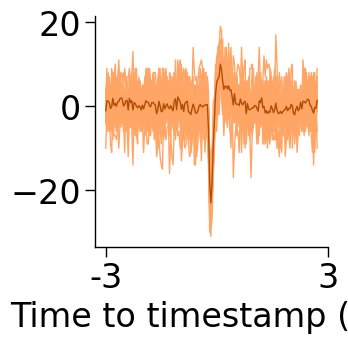

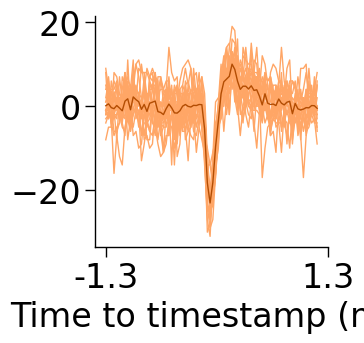

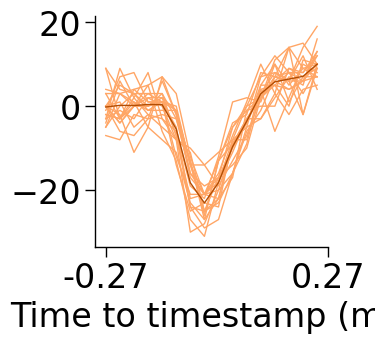

In [34]:
# takes 1 min (6 ms period, same as our simulated spikes)
fig, ax = plot_spike_profile_example(
    cell_id=23,
    ms_before=3,
    ms_after=3,
    nspike=20,
    color_mean=(0.7, 0.3, 0.01),
    color=(1, 0.65, 0.4),
)
ax.set_xticks([0, ax.get_xlim()[1]])
ax.set_xticklabels([-3, 3])
ax.set_xlabel("Time to timestamp (ms)")

# takes 1 min (period of 2.6 ms, same as Sun's cats)
fig, ax = plot_spike_profile_example(
    cell_id=23,
    ms_before=1.3,
    ms_after=1.3,
    nspike=20,
    color_mean=(0.7, 0.3, 0.01),
    color=(1, 0.65, 0.4),
)
ax.set_xticks([0, ax.get_xlim()[1]])
ax.set_xticklabels([-1.3, 1.3])
ax.set_xlabel("Time to timestamp (ms)")

# takes 1 min (period of 0.55 ms, same as Paulk's humans)
fig, ax = plot_spike_profile_example(
    cell_id=23,
    ms_before=0.27,
    ms_after=0.27,
    nspike=20,
    color_mean=(0.7, 0.3, 0.01),
    color=(1, 0.65, 0.4),
)
ax.set_xticks([0, ax.get_xlim()[1]])
ax.set_xticklabels([-0.27, 0.27])
ax.set_xlabel("Time to timestamp (ms)")

# fig

# plt.savefig(
#     "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_fast_spiking_spike_shape_2.pdf",
#     **savefig_cfg
# )
# plt.savefig(
#     "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_fast_spiking_spike_shape_2.svg",
#     **savefig_cfg
# )

# plt.show()

### Triphasic

Text(0.5, 0, 'Time to timestamp (ms)')

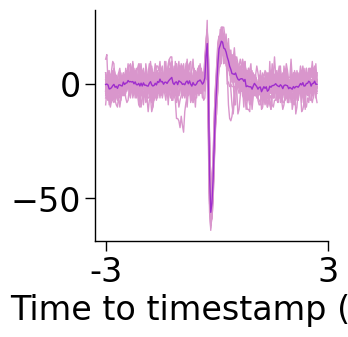

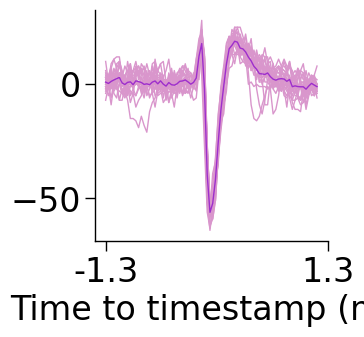

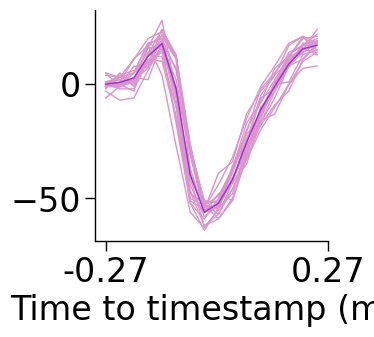

In [36]:
# takes 1 min (6 ms period, same as our simulated spikes)
fig, ax = plot_spike_profile_example(
    cell_id=24,
    ms_before=3,
    ms_after=3,
    nspike=20,
    color_mean=(0.62, 0.18, 0.8),
    color=(0.85, 0.59, 0.8),
)
ax.set_xticks([0, ax.get_xlim()[1]])
ax.set_xticklabels([-3, 3])
ax.set_xlabel("Time to timestamp (ms)")

# takes 1 min (period of 2.6 ms, same as Sun's cats)
fig, ax = plot_spike_profile_example(
    cell_id=24,
    ms_before=1.3,
    ms_after=1.3,
    nspike=20,
    color_mean=(0.62, 0.18, 0.8),
    color=(0.85, 0.59, 0.8),
)
ax.set_xticks([0, ax.get_xlim()[1]])
ax.set_xticklabels([-1.3, 1.3])
ax.set_xlabel("Time to timestamp (ms)")

# takes 1 min (period of 0.55 ms, same as Paulk's humans)
fig, ax = plot_spike_profile_example(
    cell_id=24,
    ms_before=0.27,
    ms_after=0.27,
    nspike=20,
    color_mean=(0.62, 0.18, 0.8),
    color=(0.85, 0.59, 0.8),
)
ax.set_xticks([0, ax.get_xlim()[1]])
ax.set_xticklabels([-0.27, 0.27])
ax.set_xlabel("Time to timestamp (ms)")

# plt.savefig(
#     "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_triphasic_spike_shape_3.pdf",
#     **savefig_cfg
# )
# plt.savefig(
#     "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_triphasic_spike_shape_3.svg",
#     **savefig_cfg
# )

# fig

### Compound spiking (None)

### Regular spiking

In [38]:
# takes 1 min (6 ms period, same as our simulated spikes)
fig, ax = plot_spike_profile_example(
    cell_id=8,
    ms_before=3,
    ms_after=3,
    nspike=20,
    color_mean=(0.13, 0.5, 0.8),
    color=(0.5, 0.7, 1),
)
ax.set_xticks([0, ax.get_xlim()[1]])
ax.set_xticklabels([-3, 3])
ax.set_xlabel("Time to timestamp (ms)")

# takes 1 min (period of 2.6 ms, same as Sun's cats)
fig, ax = plot_spike_profile_example(
    cell_id=8,
    ms_before=1.3,
    ms_after=1.3,
    nspike=20,
    color_mean=(0.13, 0.5, 0.8),
    color=(0.5, 0.7, 1),
)
ax.set_xticks([0, ax.get_xlim()[1]])
ax.set_xticklabels([-1.3, 1.3])
ax.set_xlabel("Time to timestamp (ms)")

# takes 1 min (period of 0.55 ms, same as Paulk's humans)
fig, ax = plot_spike_profile_example(
    cell_id=8,
    ms_before=0.27,
    ms_after=0.27,
    nspike=20,
    color_mean=(0.13, 0.5, 0.8),
    color=(0.5, 0.7, 1),
)
ax.set_xticks([0, ax.get_xlim()[1]])
ax.set_xticklabels([-0.27, 0.27])
ax.set_xlabel("Time to timestamp (ms)")

# plt.savefig(
#     "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_compound_spike_shape_4.pdf",
#     **savefig_cfg
# )
# plt.savefig(
#     "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_compound_spike_shape_4.svg",
#     **savefig_cfg
# )
# plt.show()

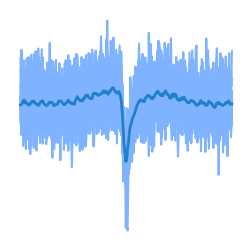

In [44]:
# # takes 1.5 min
# fig, ax = waveform.plot(
#     WaveformExtractor=WaveformExtractor,
#     cell_id=200,
#     colors=[(0.5, 0.7, 1), (0.13, 0.5, 0.8)],
#     linewidth_instance=1.5,
#     linewidth_mean=2,
#     nspike=20,  # 20 spikes
# )

# plt.axis("off")
# ax.set_title("")

# # fig

# # plt.savefig(
# #     "figures/2_realism/5_spikes/6_shape/pdf/marques/silico_marques_sorted_regular_spike_shape_5.pdf",
# #     **savefig_cfg
# # )
# # plt.savefig(
# #     "figures/2_realism/5_spikes/6_shape/svg/marques/silico_marques_sorted_regular_spike_shape_5.svg",
# #     **savefig_cfg
# # )
# # plt.show()